In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss, auc
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Imbalance tools
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
DATA_PATH = "data/heart+disease/processed.cleveland.data"

cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
        "exang","oldpeak","slope","ca","thal","target"]

df = pd.read_csv(DATA_PATH, header=None, names=cols)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
df = df.replace("?", np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Lưu lại target gốc 0..4
df["target_raw"] = df["target"].astype(int)

# Nhị phân hoá 0/1
df["target_bin"] = (df["target_raw"] > 0).astype(int)

print("Phân phối target_raw (0..4):")
print(df["target_raw"].value_counts().sort_index())

print("\nPhân phối target_bin (0/1):")
print(df["target_bin"].value_counts().sort_index())



Phân phối target_raw (0..4):
target_raw
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Phân phối target_bin (0/1):
target_bin
0    164
1    139
Name: count, dtype: int64


In [10]:
X = df.drop(columns=["target", "target_raw", "target_bin"])
y_bin = df["target_bin"]
y_multi = df["target_raw"]

X_trainval, X_test, y_bin_trainval, y_bin_test, y_multi_trainval, y_multi_test = train_test_split(
    X, y_bin, y_multi,
    test_size=0.2,
    stratify=y_bin,  # hoặc stratify=y_multi
    random_state=42
)
print("\nKích thước tập:")
print("trainval:", len(X_trainval), "| test:", len(X_test))



Kích thước tập:
trainval: 242 | test: 61


## Preprocess chung

In [11]:
num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal"]

def make_preprocess():
    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    pre = ColumnTransformer(transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ])
    return pre

preprocess = make_preprocess()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Hàm eval cho binary

In [12]:
def fit_eval_binary(model, name, preprocess,
                    X_trainval, y_trainval, X_test, y_test, cv):
    """
    Bài toán: binary (0 vs 1–4)
    Metric: AUC, Accuracy, Precision, Recall, F1
    """
    pipe = Pipeline(steps=[("pre", preprocess), ("clf", model)])

    # Out-of-fold prob để tính Val AUC
    oof_proba = cross_val_predict(
        pipe,
        X_trainval, y_trainval,
        cv=cv,
        method="predict_proba",
        n_jobs=-1
    )[:, 1]
    val_auc = roc_auc_score(y_trainval, oof_proba)

    # Fit lại trên toàn bộ trainval
    pipe.fit(X_trainval, y_trainval)

    # Đánh giá trên TEST
    test_proba = pipe.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= 0.5).astype(int)

    metrics = {
        "Setting": "Binary (0 vs 1–4)",
        "Model": name,
        "Val AUC": val_auc,
        "Test AUC": roc_auc_score(y_test, test_proba),
        "Accuracy": accuracy_score(y_test, test_pred),
        "Precision": precision_score(y_test, test_pred, zero_division=0),
        "Recall": recall_score(y_test, test_pred, zero_division=0),
        "F1": f1_score(y_test, test_pred, zero_division=0),
        "pipe": pipe,
        "test_proba": test_proba,
        "test_pred": test_pred,
    }
    return metrics

## Hàm eval cho multi-class 0..4

In [13]:

def fit_eval_multiclass(model, name, preprocess,
                        X_trainval, y_trainval, X_test, y_test, cv):
    """
    Bài toán: 5 lớp (0,1,2,3,4)
    Metric: Accuracy, F1-macro
    (AUC multi-class thì có thể tính thêm nếu cần)
    """
    pipe = Pipeline(steps=[("pre", preprocess), ("clf", model)])

    # Out-of-fold predict label để tính Val Acc/F1-macro
    oof_pred = cross_val_predict(
        pipe,
        X_trainval, y_trainval,
        cv=cv,
        method="predict",
        n_jobs=-1
    )
    val_acc = accuracy_score(y_trainval, oof_pred)
    val_f1_macro = f1_score(y_trainval, oof_pred, average="macro")

    # Fit lại trên toàn bộ trainval
    pipe.fit(X_trainval, y_trainval)

    # Đánh giá trên TEST
    test_pred = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_f1_macro = f1_score(y_test, test_pred, average="macro")

    metrics = {
        "Setting": "Multi-class (0–4)",
        "Model": name,
        "Val Acc": val_acc,
        "Val F1_macro": val_f1_macro,
        "Test Acc": test_acc,
        "Test F1_macro": test_f1_macro,
        "pipe": pipe,
        "test_pred": test_pred,
    }
    return metrics

## Chọn 1 model chung: RandomForest

In [14]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced"
)

res_bin = fit_eval_binary(
    rf, "Random Forest",
    preprocess,
    X_trainval, y_bin_trainval,
    X_test, y_bin_test,
    skf
)

res_multi = fit_eval_multiclass(
    rf, "Random Forest",
    preprocess,
    X_trainval, y_multi_trainval,
    X_test, y_multi_test,
    skf
)

## Bảng so sánh tổng hợp

In [15]:
summary_bin = pd.DataFrame([{
    "Setting": res_bin["Setting"],
    "Model": res_bin["Model"],
    "Val AUC": round(res_bin["Val AUC"], 3),
    "Test AUC": round(res_bin["Test AUC"], 3),
    "Accuracy": round(res_bin["Accuracy"], 3),
    "Precision": round(res_bin["Precision"], 3),
    "Recall": round(res_bin["Recall"], 3),
    "F1": round(res_bin["F1"], 3),
}])

summary_multi = pd.DataFrame([{
    "Setting": res_multi["Setting"],
    "Model": res_multi["Model"],
    "Val Acc": round(res_multi["Val Acc"], 3),
    "Val F1_macro": round(res_multi["Val F1_macro"], 3),
    "Test Acc": round(res_multi["Test Acc"], 3),
    "Test F1_macro": round(res_multi["Test F1_macro"], 3),
}])

print("\nKết quả Binary (0 vs 1–4) ")
print(summary_bin)

print("\nKết quả Multi-class (0–4)")
print(summary_multi)


Kết quả Binary (0 vs 1–4) 
             Setting          Model  Val AUC  Test AUC  Accuracy  Precision  \
0  Binary (0 vs 1–4)  Random Forest    0.891     0.948     0.885      0.839   

   Recall     F1  
0   0.929  0.881  

Kết quả Multi-class (0–4)
             Setting          Model  Val Acc  Val F1_macro  Test Acc  \
0  Multi-class (0–4)  Random Forest    0.562         0.295      0.59   

   Test F1_macro  
0          0.292  


## Confusion matrix để nhìn trực quan

<Figure size 400x400 with 0 Axes>

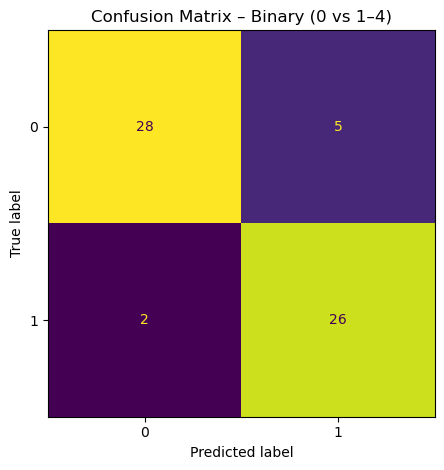

<Figure size 500x400 with 0 Axes>

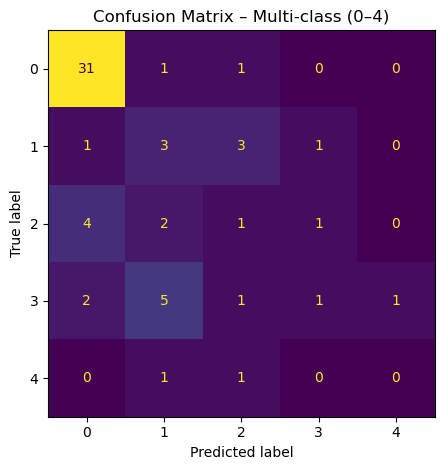

In [16]:
# Binary
plt.figure(figsize=(4,4))
cm_bin = confusion_matrix(y_bin_test, res_bin["test_pred"])
disp_bin = ConfusionMatrixDisplay(cm_bin, display_labels=[0,1])
disp_bin.plot(colorbar=False)
plt.title("Confusion Matrix – Binary (0 vs 1–4)")
plt.tight_layout()
plt.show()

# Multi-class
plt.figure(figsize=(5,4))
cm_multi = confusion_matrix(y_multi_test, res_multi["test_pred"])
disp_multi = ConfusionMatrixDisplay(
    cm_multi,
    display_labels=[0,1,2,3,4]
)
disp_multi.plot(colorbar=False)
plt.title("Confusion Matrix – Multi-class (0–4)")
plt.tight_layout()
plt.show()